#### Housekeeping

In [1]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets
from IPython.display import display

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

Updating the local database...
Done
Internal Structure of therpy has changed.
Now all functions (except for helper functions and imageio functions) are stored at one place therpy.funcs and available on root as tp.####.
If there are errors in your program, simply replace tp.module_name.func_name to tp.func_name.
If some function is not present there, it must be a helper function and can be accessed via tp.funcs._____
If you would like to go back to old therpy, use pip install therpy==0.2.5 


In [2]:
def dataset_counter(df, bg_param, bg_value, x='x', plot=False, ax=None, xlabel='x'):
    '''
    count the occurances of various x data points and bg points 
    '''
    # Count number of images 
    unique_x = np.unique(df[x])
    data_counts = np.array([np.sum(df[x][df[bg_param] != bg_value] == xi) for xi in unique_x])
    bg_counts = np.array([np.sum(df[x][df[bg_param] == bg_value] == xi) for xi in unique_x])
    dataset_counter = [unique_x, data_counts, bg_counts]
    
    # Plot
    if plot: 
        ax = plt.subplots(figsize=[15,4])[1] if (ax is None) else ax
        width = np.min(np.diff(dataset_counter[0]))*0.75 if (len(dataset_counter[0]) > 1) else 1
        ax.bar(dataset_counter[0], dataset_counter[1], width, label='Data')
        ax.bar(dataset_counter[0], dataset_counter[2], width, bottom=dataset_counter[1], label='BG')
        ax.legend()
        ax.set(xlabel = xlabel, ylabel='Shots')
        plt.tight_layout()
    
    return dataset_counter

In [3]:
# Constants 
import_params = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'SeqMode']

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

fontsize = 15

In [4]:
# Specific Functions 

def sin_decay(x, wavelength=1, kappa=0, amplitude=1, phase=0, a0=0, a1=0, a2=0):
    return amplitude * np.exp(- x * kappa) * np.sin(twopi/wavelength * x - phase) + a0 + a1*x + a2*x**2

def calculate_data_sharedBG_usingCenter(df):
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_parameter] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_parameter] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]

    # Gather nz_raw 
    df['nz_raw'] = [im.nz for im in tqdm(df.image)]
    
    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = tp.erf(x, x1, s1) + tp.erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

    # Get the background profile 
    bg_ind = (df[background_parameter] == background_value)
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf])
    nz_bg_all = [tp.Curve(r.nz_raw.x - (r.fitres_erf[0] + r.fitres_erf[1])/2 + length/2, 
        (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_parameter] != background_value) & (df.x == x)

        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]

        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - (r.fitres_erf[0] + r.fitres_erf[1])/2 + length/2, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]

        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    

    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    return df_data

def calculate_data_sharedBG_usingTopEdge(df):
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_parameter] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_parameter] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]
    
    # Gather nz_raw 
    df['nz_raw'] = [im.nz for im in tqdm(df.image)]
    
    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = tp.erf(x, x1, s1) + tp.erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

    # Get the background profile 
    bg_ind = (df[background_parameter] == background_value)
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf])
    nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
        (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_parameter] != background_value) & (df.x == x)

        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]

        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]

        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    

    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    return df_data

def calculate_shifted_app_center(df, df_data): 
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = (r.fitres_erf[0] + r.fitres_erf[1])/2
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)

    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean
        

def calculate_shifted_app_TopEdge(df, df_data): 
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = r.fitres_erf[1]
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)

    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean


# Load Data from Images 

In [933]:
df_all = pd.DataFrame()

In [934]:
# Relevant Parameters 
x_var_name = 'BoxShakeFreq'
x_var_label = r'$\nu$ (Hz)'
background_parameter = 'ShakingCycles'
background_value = 0
threshold_image_num = 1
image_use = 'A'

In [1568]:
# Import from Clipboard 
df_all = tp.images_from_clipboard(df=df_all, x=x_var_name, params=import_params, 
                                  image_func=tp.Hybrid_Image, download=image_use, display=True)


Updating the local database...
Done

Total Number of Shots 119, Images 119


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,...,ShakeWait,HeatCycles,ShakingCycles,BoxShakeFreq,BoxShakeAmp,BoxShakeTime,SeqMode,x,total_atoms,use
name,,,,,,,,,,,,,,,,,,,,,
08-30-2017_20_28_07_TopA,0.0,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,0.0,0.0,77.0,0.3,0.0,None,77.0,466529,1.0
08-30-2017_20_29_01_TopA,0.9,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,0.0,0.0,77.0,0.3,0.0,None,77.0,472914,1.0
08-30-2017_20_29_55_TopA,1.8,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,0.0,0.0,77.0,0.3,0.0,None,77.0,451854,1.0


In [1569]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1376, fudge=1.75, width=800, height=800, subsample=3, 
                  xsec_extension='poly0', xsec_slice_width=7, xsec_fit_range=1.0, radial_selection=0.9,)}

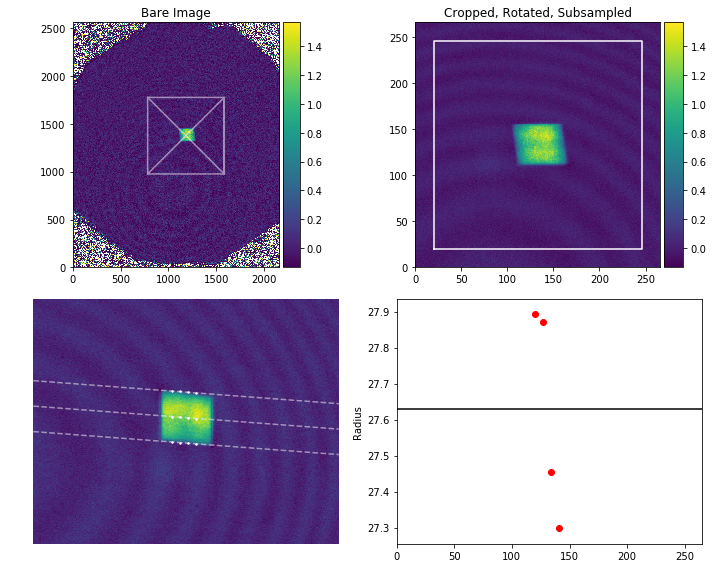

In [1570]:
# Verify Settings 

# Apply to all Images 
for n,r in df_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_all.shape[0])):
    r = df_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()
    plt.show()

if df_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_all.shape[0]-1))


Total Images 119 ==> Good 113, Bad 6


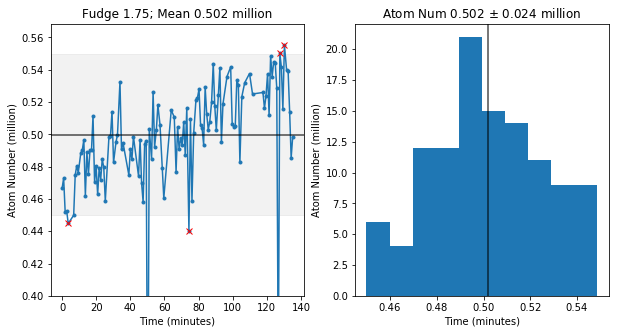

In [1571]:
# Atom Number Filter 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
ax = tp.atom_num_filter(df=df_all, keep=0.10, offset=0.0, display=True, plot=True)
ax[0].set(ylim=[0.4,None])
df = df_all[df_all.use]

[  77.   100.   105.   110.   115.   120.   125.   130.   132.5  135.
  137.5  140.   142.5  145.   147.5  150.   152.5  155.   160.   165.   170.
  175.   180.   185.   190.   195.   200.   205.   210.   215.   220.   230.
  240.   250.   260.   270.   280.   290.   300.   310.   320.   330.   340.
  350.   360.   370.   380.   390.   400.   410.   420.   430.   440.   450.
  460.   470.   480.   490.   500.   510.   520.   530.   540.   550.   560.
  570.   580.   590.   600.   610.   620.   630.   650.   670.   680.   690.
  700.   710.   720.   730.   740.   750.   760.   770.   780.   790.   800.
  810.   820.   830.   840.   850.   880.   890. ]


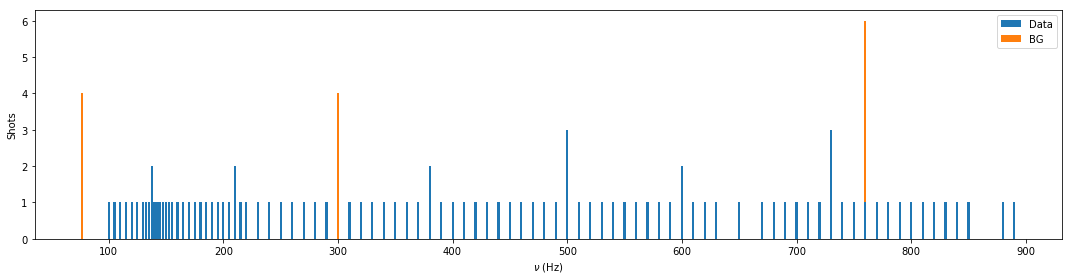

In [1572]:
# Dataset Explorer 
ds_counter = dataset_counter(df=df, bg_param=background_parameter, bg_value=background_value, plot=True, xlabel=x_var_label)
print(np.unique(df.x.values))

In [1573]:
# Compute df_data and dict_data 
# df_data = calculate_data_sharedBG_usingTopEdge(df)
# calculate_shifted_app_TopEdge(df, df_data)

df_data = calculate_data_sharedBG_usingCenter(df)
calculate_shifted_app_center(df, df_data)

dict_data = dict()


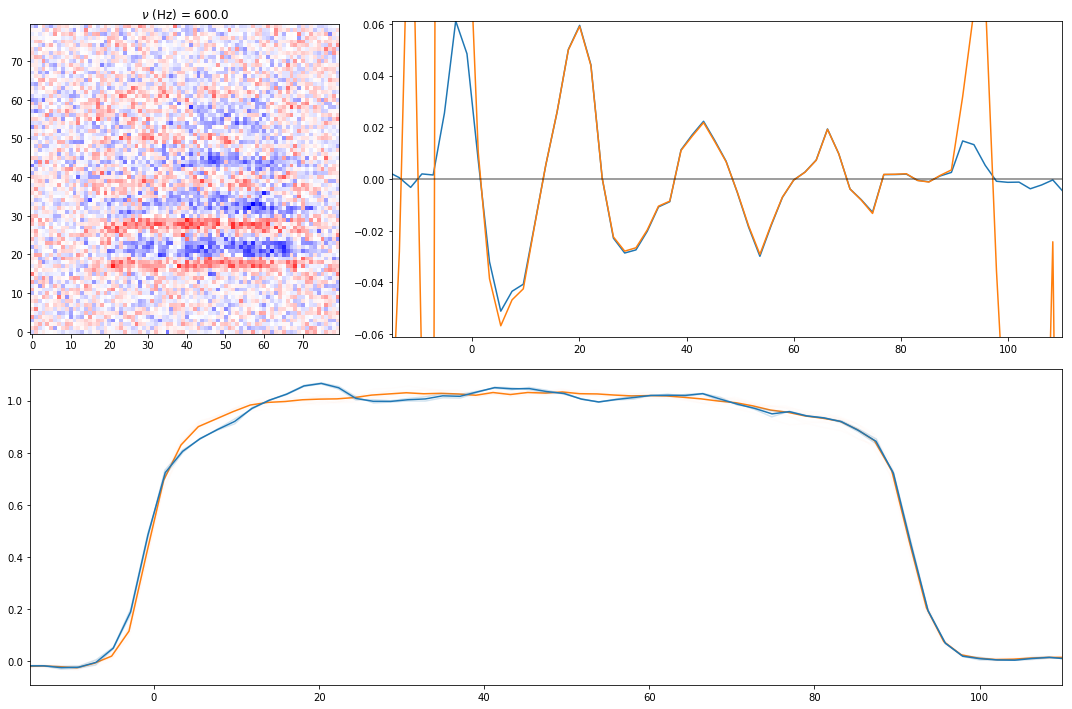

In [1574]:
# Plot 2D Images and integrated profiles 
plot_xlim = [-15, 110]
def temp(test=np.random.randint(0, df_data.shape[0])):
    r = df_data.iloc[test]
    app = r['2D Delta rho']
    roi = tp.get_roi(app, width=80, height=80)
    clim = np.max(np.abs(app[roi])) * 1.0
    clim = [-clim, clim]
    fig = plt.figure(figsize=[15, 10])
    # Plot Image
    plt.subplot2grid((2,3),(0,0))
    plt.imshow(app[roi], origin=0, clim=clim, cmap='bwr')
    plt.title("{} = {}".format(x_var_label, r.name))
    # Plot Average delta rho 
    plt.subplot2grid((2,3),(0,1),colspan=2 )
    c = tp.Curve(r['Delta rho'].x * 1e6, r['Delta rho'].y / r.amp)
    ymax = np.max(np.abs(c.y))
    plt.plot(*c.data)
    c = tp.Curve(r['Delta rho / rho'].x * 1e6, r['Delta rho / rho'].y)
    plt.plot(*c.data)
    plt.ylim([-ymax, ymax])
    plt.axhline(0, c='k', alpha=0.5)
    plt.xlim(plot_xlim)
    # Plot All BG and Data nz 
    plt.subplot2grid((2,1),(1,0))
    for n in r['nz bg all']:
        plt.plot(n.x*1e6, n.y/r.amp, 'C1-', alpha=0.01)
    plt.plot(r['nz bg'].x*1e6, r['nz bg'].y / r.amp, 'C1-')
    for n in r['nz data all']:
        plt.plot(n.x*1e6, n.y/r.amp, 'C0-', alpha=0.2)
    plt.plot(r['nz data'].x*1e6, r['nz data'].y / r.amp, 'C0-')
    plt.xlim(plot_xlim)
    plt.tight_layout()
    plt.show()

if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

In [1575]:
# # Trimming the dataset 
# df_data = df_data[df_data.index <= 500]

# Single Sided Decay Fits

In [15]:
# Reduced Plots and Info for Faster Processing 
savefig = ipywidgets.Checkbox(value=False, description='Save Fig')
display(savefig)
folder_name = df.iloc[0].name[0:14] + 'OneSidedDecay'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix

'07-24-2017_21_OneSidedDecay/'

In [16]:
# Dataset Info 
speed_sound_guess = 18 * 1e-6/1e-3
fit_lims = np.array([10, 70])
plot_lims = np.array([-10, 100])

In [18]:
# Prepare for fit 
df_data['fitres'] = None
df_data['fit_guess'] = [dict(wavelength = [speed_sound_guess / r.freq * 1e6, r'$\mu m$'], 
                             kappa = [1/50, r'1/$\mu m$'], 
                             amplitude = [5, '%'], phase = [0, 'rad'], a0 = 1e-1,) for n,r in df_data.iterrows()]
df_data['fit_fixed'] = [dict() for n,r in df_data.iterrows()]

# Override guess for specific dataset 
# df_data.loc[800, 'fit_guess']['a1'] = 1e-3
# df_data.loc[800, 'fit_guess']['a2'] = 1e-3
# df_data.loc[1001, 'fit_guess']['a1'] = 1e-3
# df_data.loc[1051, 'fit_guess']['a1'] = 1e-3
# df_data.loc[1101, 'fit_guess']['a1'] = 1e-3
# df_data.loc[1151, 'fit_guess']['a1'] = 1e-3
# df_data.loc[1201, 'fit_guess']['a1'] = 1e-3
# df_data.loc[1250, 'fit_guess']['a1'] = 1e-3
# df_data.loc[1251, 'fit_guess']['a1'] = 1e-3

# Remove some data points 
df_data['use'] = True
# df_data.loc[1301, 'use'] = False
# df_data.loc[1400, 'use'] = False
# df_data.loc[1500, 'use'] = False

In [20]:
# Fit and Plot Tests 
use = 'Delta rho / rho'
def temp(test=np.random.randint(0, df_data.shape[0]), plot=True):
    r = df_data.iloc[test]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    xp = np.linspace(plot_lims[0], plot_lims[1], 1000)
    cf = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=fit_lims).data, plot=False, info=True, fixed=r.fit_fixed)
    df_data.loc[r.name, 'fitres'] = cf
    if plot:
        fig = plt.figure(figsize=[7, 4.5])
        plt.plot(xp, cf(xp), 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(r.length*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, cf(c.x, amplitude=0), 'C2-', alpha=0.5)
        amp = abs(cf['amplitude']) * 1.5
        if amp >= 10: amp = 9.99
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.xlabel(r'z ($\mu m$)', fontsize=15)
        plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("{} = {}".format(x_var_label, r.name), fontsize=15)
        plt.tight_layout()
        plt.show()
        if savefig.value: fig.savefig(suffix + 'SampleFits-{}.pdf'.format(r.name))
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

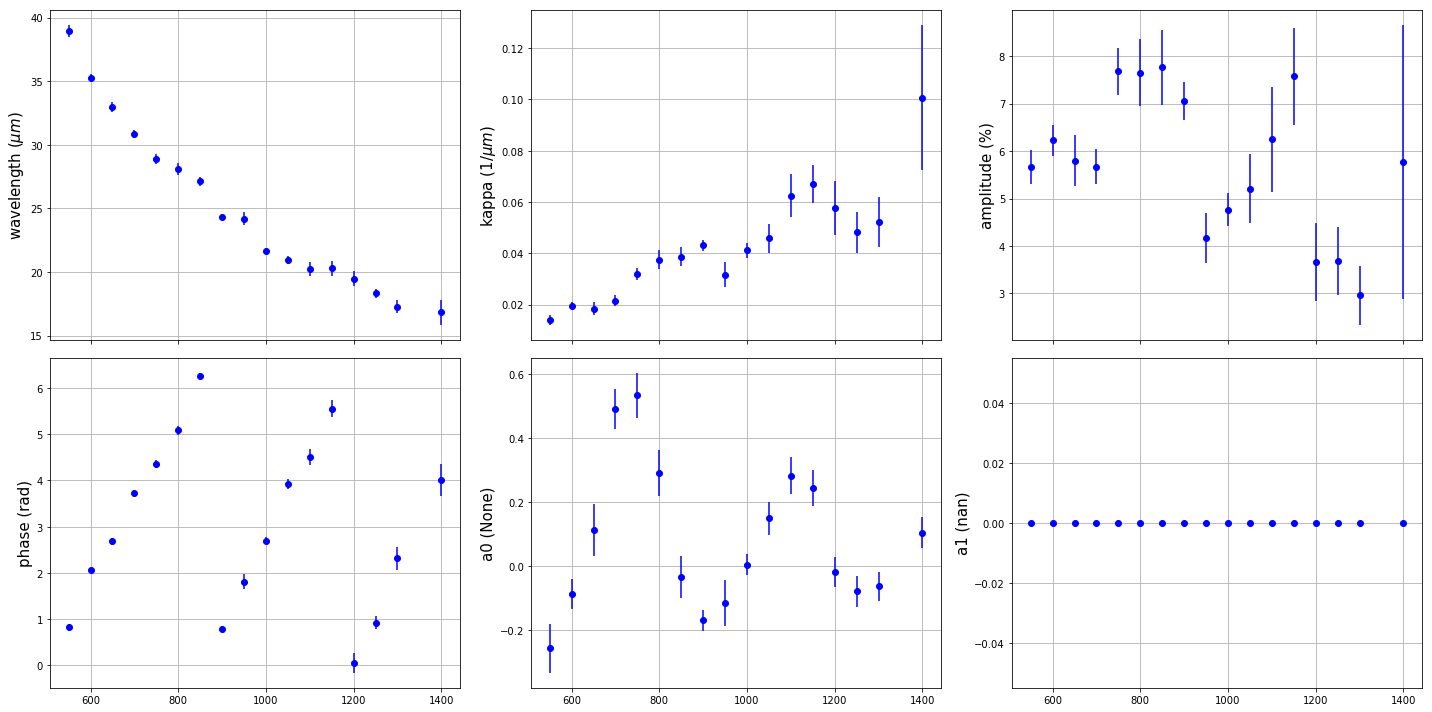

In [21]:
# Fit all and raw plot 
for n,r in df_data.iterrows():
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    df_data.loc[r.name, 'fitres'] = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=fit_lims).data, fixed=r.fit_fixed)

# Fix phase and amp 
for n,r in df_data.iterrows():
    if r.fitres['amplitude'] < 0:
        r.fitres.fr.loc['amplitude','FitValue'] = - r.fitres['amplitude']
        r.fitres.fr.loc['phase','FitValue'] = r.fitres['phase'] + np.pi
    r.fitres.fr.loc['phase','FitValue'] = np.mod(r.fitres.fr.loc['phase','FitValue'], twopi)

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[20,10], sharex=True)
fn_ = df_data.iloc[0].fitres.fr.index.values
fu_ = df_data.iloc[0].fitres.fr['Units'].values
ax = ax.flatten()
for i in range(6):
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres], [fr.fe[i] for fr in df_data[df_data.use].fitres], fmt='bo')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres], [fr.fe[i] for fr in df_data[~df_data.use].fitres], fmt='ro')
    ax[i].set_ylabel("{} ({})".format(fn_[i], fu_[i]), fontsize=15)
    ax[i].grid()
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'RawFits-v1.pdf')

## vs $\omega$

### Speed of Sound

In [22]:
# Extract Dispersion Relation 
disprel = pd.DataFrame()
disprel['freq (Hz)'] = df_data[df_data.use].freq.values
disprel['wavelength (m)'] = np.array([r.fitres['wavelength'] * 1e-6 for n,r in df_data[df_data.use].iterrows()])
disprel['wavelength error'] = np.array([r.fitres.fe['wavelength'] * 1e-6 for n,r in df_data[df_data.use].iterrows()])
disprel['speed (m/s)'] = disprel['wavelength (m)'] * disprel['freq (Hz)'] 
disprel['speed error'] = disprel['wavelength error'] * disprel['freq (Hz)'] 
disprel['omega (1/s)'] = twopi * disprel['freq (Hz)'] 
disprel['k (1/m)'] = twopi / disprel['wavelength (m)'] 
disprel['k error'] = disprel['wavelength error'] * twopi / disprel['wavelength (m)']**2 

dict_data['disprel'] = disprel
disprel.head(2)

,freq (Hz),wavelength (m),wavelength error,speed (m/s),speed error,omega (1/s),k (1/m),k error
0,550.0,0.000039,4.873334e-07,0.021419,0.000268,3455.751919,161337.404927,2018.907546
1,600.0,0.000035,2.476047e-07,0.021178,0.000149,3769.911184,178014.386532,1248.789432


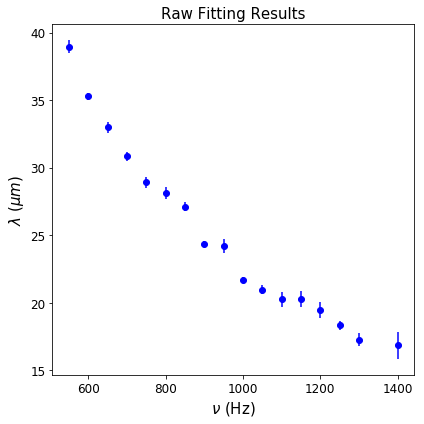

In [23]:
# Plot Raw Fitting Results 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(disprel['freq (Hz)'], disprel['wavelength (m)']*1e6, yerr=disprel['wavelength error']*1e6, fmt='bo', )
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\lambda$ ($\mu m$)', fontsize=15)
plt.title(r'Raw Fitting Results', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

        FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
c       0.022549  0.000179  None    1.0        -inf         inf   0.791714
offset  0.000000  0.000000   NaN    0.0    0.000000    0.000000   0.000000


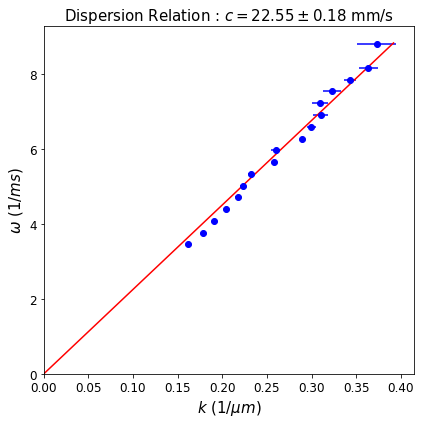

In [24]:
# Plot omega vs k 
# line fit 
dispersion_fit = tp.curve_fit(lambda x, c=1, offset=0: offset + c*x, [1,], disprel['k (1/m)'], disprel['omega (1/s)'], plot=False, info=True)
c = dispersion_fit['c'] * 1e3
c_error = dispersion_fit.fe['c'] * 1e3
dict_data['dispersion_fit'] = dispersion_fit

fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(disprel['k (1/m)']*1e-6, disprel['omega (1/s)']*1e-3, xerr=disprel['k error']*1e-6, fmt='bo', )
xp = np.linspace(0, np.max(disprel['k (1/m)']*1e-6)*1.05)
plt.plot(xp, c*xp, 'r')
plt.xlabel(r'$k$ ($1/\mu m$)', fontsize=15)
plt.ylabel(r'$\omega$ ($1/ms$)', fontsize=15)
plt.title(r'Dispersion Relation : $c = {:.2f} \pm {:.2f}$ mm/s'.format(c, c_error), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,None])
plt.ylim([0,None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'DispersionRelation-v1.pdf')

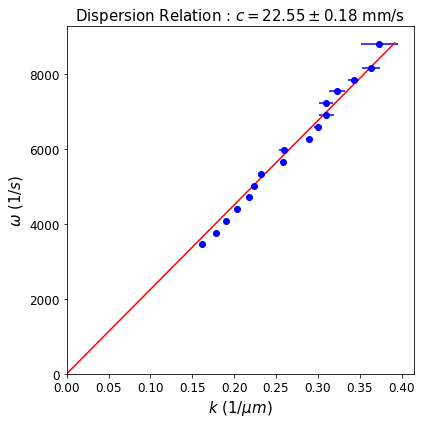

In [25]:
# Plot omega vs k 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(disprel['k (1/m)']*1e-6, disprel['omega (1/s)'], xerr=disprel['k error']*1e-6, fmt='bo', )
xp = np.linspace(0, np.max(disprel['k (1/m)']*1e-6)*1.05)
plt.plot(xp, c*xp * 1e3, 'r')
plt.xlabel(r'$k$ ($1/\mu m$)', fontsize=15)
plt.ylabel(r'$\omega$ ($1/s$)', fontsize=15)
plt.title(r'Dispersion Relation : $c = {:.2f} \pm {:.2f}$ mm/s'.format(c, c_error), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,None])
plt.ylim([0,None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'DispersionRelation-v2.pdf')

In [26]:
# Save Data to Excel 
if savefig.value: disprel.to_excel(suffix + 'DispersionRelation-Data.xlsx')

### Decay Rate $\Gamma$

In [29]:
# Decay Rate Extraction 
decay = disprel.copy()
decay['kappa (1/m)'] = np.array([r.fitres['kappa'] * 1e6 for n,r in df_data[df_data.use].iterrows()])
decay['kappa error'] = np.array([r.fitres.fe['kappa'] * 1e6 for n,r in df_data[df_data.use].iterrows()])
decay['gamma (1/s)'] = 2 * decay['kappa (1/m)'] * decay['speed (m/s)'] 
decay['gamma error'] = 2 * np.sqrt((decay['speed error'] * decay['kappa (1/m)'])**2 + (decay['speed (m/s)'] * decay['kappa error'])**2)
decay['amplitude (%)'] = np.array([r.fitres.fv['amplitude'] for n,r in df_data[df_data.use].iterrows()])
dict_data['decay'] = decay
decay.head(3)

,freq (Hz),wavelength (m),wavelength error,speed (m/s),speed error,omega (1/s),k (1/m),k error,kappa (1/m),kappa error,gamma (1/s),gamma error,amplitude (%)
0,550.0,0.000039,4.873334e-07,0.021419,0.000268,3455.751919,161337.404927,2018.907546,13958.602871,1860.250429,597.970058,80.041464,5.663580
1,600.0,0.000035,2.476047e-07,0.021178,0.000149,3769.911184,178014.386532,1248.789432,19545.964451,1557.969020,827.871853,66.243050,6.228172
2,650.0,0.000033,3.749288e-07,0.021437,0.000244,4084.070450,190511.222519,2165.758514,18449.806954,2634.409104,791.032784,113.307315,5.796492


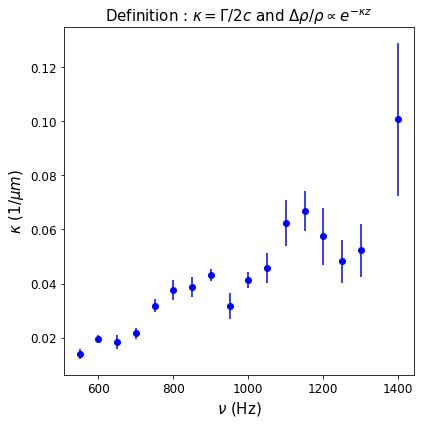

In [30]:
# Plot Raw Fitting Results 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(decay['freq (Hz)'], decay['kappa (1/m)']*1e-6, yerr=decay['kappa error']*1e-6, fmt='bo', )
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\kappa$ ($1/\mu m$)', fontsize=15)
plt.title(r'Definition : $\kappa = \Gamma / 2c$ and $\Delta\rho/\rho \propto e^{-\kappa z}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

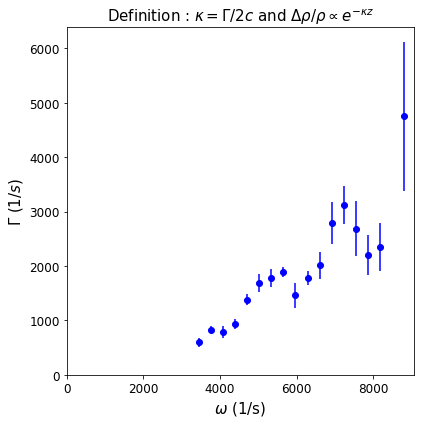

In [31]:
# Plot Raw Fitting Results 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(decay['omega (1/s)'], decay['gamma (1/s)'], yerr=decay['gamma error'], fmt='bo', )
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ ($1/s$)', fontsize=15)
plt.title(r'Definition : $\kappa = \Gamma / 2c$ and $\Delta\rho/\rho \propto e^{-\kappa z}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'GammaVsOmega-v1.pdf')

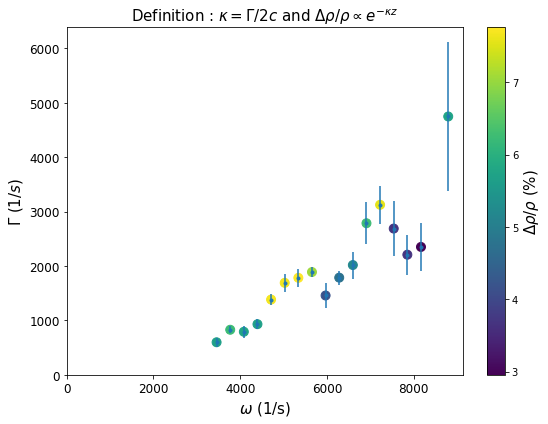

In [32]:
# Plot Raw Fitting Results 
fig, ax = plt.subplots(figsize=[8,6])
plt.errorbar(decay['omega (1/s)'], decay['gamma (1/s)'], yerr=decay['gamma error'], fmt='.', )
plt.scatter(decay['omega (1/s)'], decay['gamma (1/s)'], c=decay['amplitude (%)'], cmap='viridis', s=80)
clb = plt.colorbar()
clb.set_label(r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ ($1/s$)', fontsize=15)
plt.title(r'Definition : $\kappa = \Gamma / 2c$ and $\Delta\rho/\rho \propto e^{-\kappa z}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'GammaVsOmega-v2.pdf')

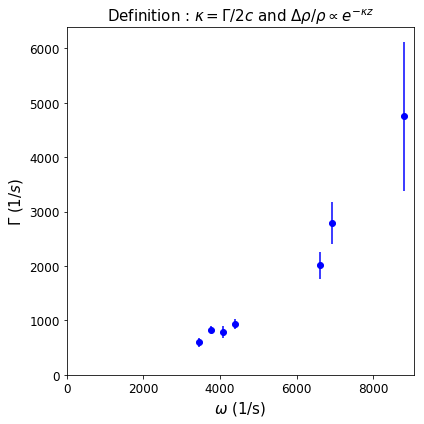

In [33]:
# Plot Raw Fitting Results 
amp_lims = [5, 6.5]
decay_ = decay[(decay['amplitude (%)'] >= amp_lims[0]) & (decay['amplitude (%)'] <= amp_lims[1])]
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(decay_['omega (1/s)'], decay_['gamma (1/s)'], yerr=decay_['gamma error'], fmt='bo', )
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ ($1/s$)', fontsize=15)
plt.title(r'Definition : $\kappa = \Gamma / 2c$ and $\Delta\rho/\rho \propto e^{-\kappa z}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'GammaVsOmega-AmpSelection.pdf')

In [34]:
# Save Data to Excel 
if savefig.value: disprel.to_excel(suffix + 'GammaVsOmega-Data.xlsx')

### Decay Rate $\Gamma$ -- Overridden $c$

In [ ]:
# Fit and Plot Tests 
use = 'Delta rho / rho'
speed_sound = dict_data['dispersion_fit']['c']
def temp(test=np.random.randint(0, df_data.shape[0]), plot=True):
    r = df_data.iloc[test]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    xp = np.linspace(plot_lims[0], plot_lims[1], 1000)
    guess = r.fit_guess.copy()
    del guess['wavelength']
    guess['a1'] = 1e-3
    fixed = r.fit_fixed
    fixed['wavelength'] = speed_sound / r.freq * 1e6
    cf = tp.curve_fit(sin_decay, guess, *c.trim(xlim=fit_lims).data, plot=False, info=True, fixed=fixed)
    if plot:
        fig = plt.figure(figsize=[7, 4.5])
        plt.plot(xp, cf(xp), 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(r.length*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, cf(c.x, amplitude=0), 'C2-', alpha=0.5)
        amp = abs(cf['amplitude']) * 1.5
        if amp >= 10: amp = 9.99
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.xlabel(r'z ($\mu m$)', fontsize=15)
        plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("{} = {}".format(x_var_label, r.name), fontsize=15)
        plt.tight_layout()
        plt.show()
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

In [ ]:
# Fit with overriden 
df_data['fitres_c'] = None

# Fit all and draw plot 
for n,r in df_data.iterrows():
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    guess = r.fit_guess.copy()
    del guess['wavelength']
    fixed = r.fit_fixed
    fixed['wavelength'] = speed_sound / r.freq * 1e6
    df_data.loc[r.name, 'fitres_c'] = tp.curve_fit(sin_decay, guess, *c.trim(xlim=fit_lims).data, fixed=fixed)

# Fix phase and amp 
for n,r in df_data.iterrows():
    if r.fitres_c['amplitude'] < 0:
        r.fitres_c.fr.loc['amplitude','FitValue'] = - r.fitres_c['amplitude']
        r.fitres_c.fr.loc['phase','FitValue'] = r.fitres_c['phase'] + np.pi
    r.fitres_c.fr.loc['phase','FitValue'] = np.mod(r.fitres_c.fr.loc['phase','FitValue'], twopi)

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[20,10], sharex=True)
fn_ = df_data.iloc[0].fitres_c.fr.index.values
fu_ = df_data.iloc[0].fitres_c.fr['Units'].values
ax = ax.flatten()
for i in range(6):
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres_c], [fr.fe[i] for fr in df_data[df_data.use].fitres_c], fmt='bo')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres_c], [fr.fe[i] for fr in df_data[~df_data.use].fitres_c], fmt='ro')
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres], [fr.fe[i] for fr in df_data[df_data.use].fitres], fmt='bx')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres], [fr.fe[i] for fr in df_data[~df_data.use].fitres], fmt='rx')
    ax[i].set_ylabel("{} ({})".format(fn_[i], fu_[i]), fontsize=15)
    ax[i].grid()
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'RawFits-FixedC-v1.pdf')

### Next

# Sonogram

In [1576]:
# Saving Figures 
savefig = ipywidgets.Checkbox(value=False, description='Save Fig')
display(savefig)
folder_name = df.iloc[0].name[0:14] + 'Sonogram'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix

'08-30-2017_20_Sonogram\\'

## 2D Movies

In [1591]:
# Compute movies 
z_lims = np.array([-10, 105]) * 1e-6
use = 'Delta rho'
movie = np.array([nz.trim(xlim=z_lims).y for nz in df_data[use]]).T / np.mean(df_data.amp)
movie = [df_data.index.values, df_data[use].iloc[0].trim(xlim=z_lims).x*1e6, movie]

In [1592]:
# Compute FT 
L = np.mean(df_data.length) * 1e6
kscale = np.pi/L
k = np.arange(0, 15 * kscale, 1 * kscale)
ft = np.array([tp.fourier_transform(movie[1], movie[2][:, i], k)[1] for i in range(movie[0].size)]).T
ft_real = [movie[0], k/kscale, np.real(ft)]
ft_imag = [movie[0], k/kscale, np.imag(ft)]
ft_abs = [movie[0], k/kscale, np.abs(ft)]

In [1593]:
# Plot Prep 
clim_movie = np.max(np.abs(movie[2])) * 0.8
clim_ft = np.max(np.abs(ft_abs[2])) * 0.5

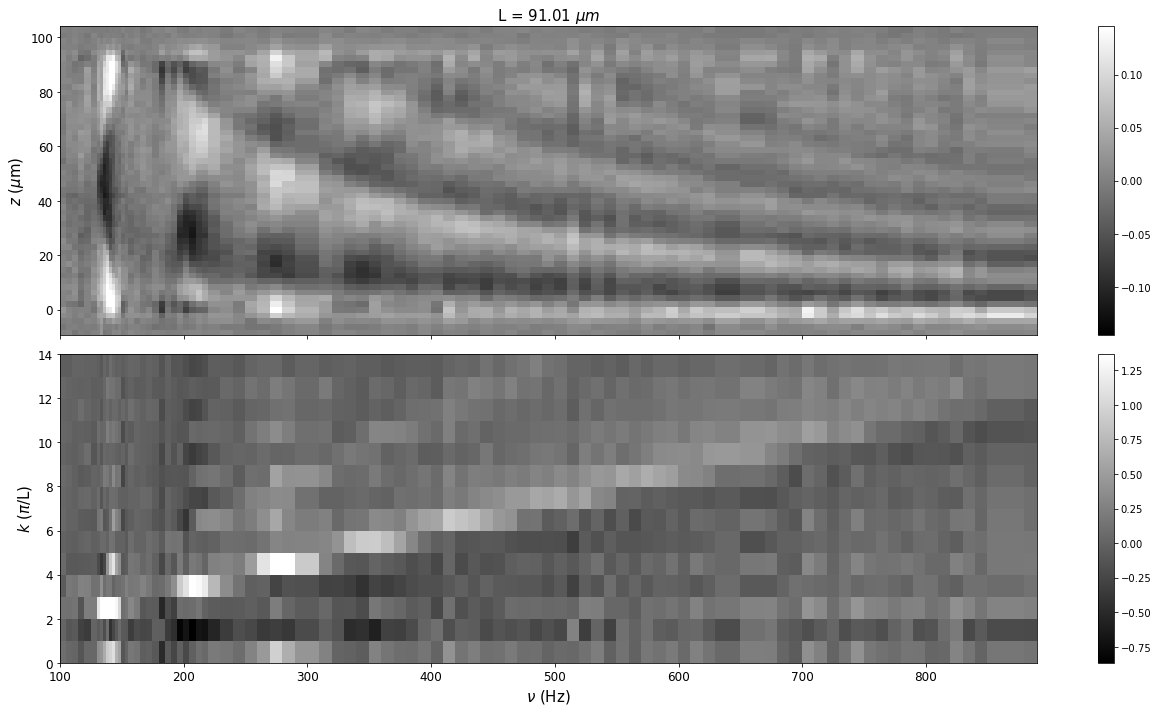

In [1594]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[18, 10], sharex=True)
plt.sca(ax[0])
plt.pcolor(*movie, cmap='gray', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar()
plt.sca(ax[1])
plt.pcolor(*ft_real, cmap='gray', linewidth=0, vmax=clim_ft)
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar()
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v1.pdf')

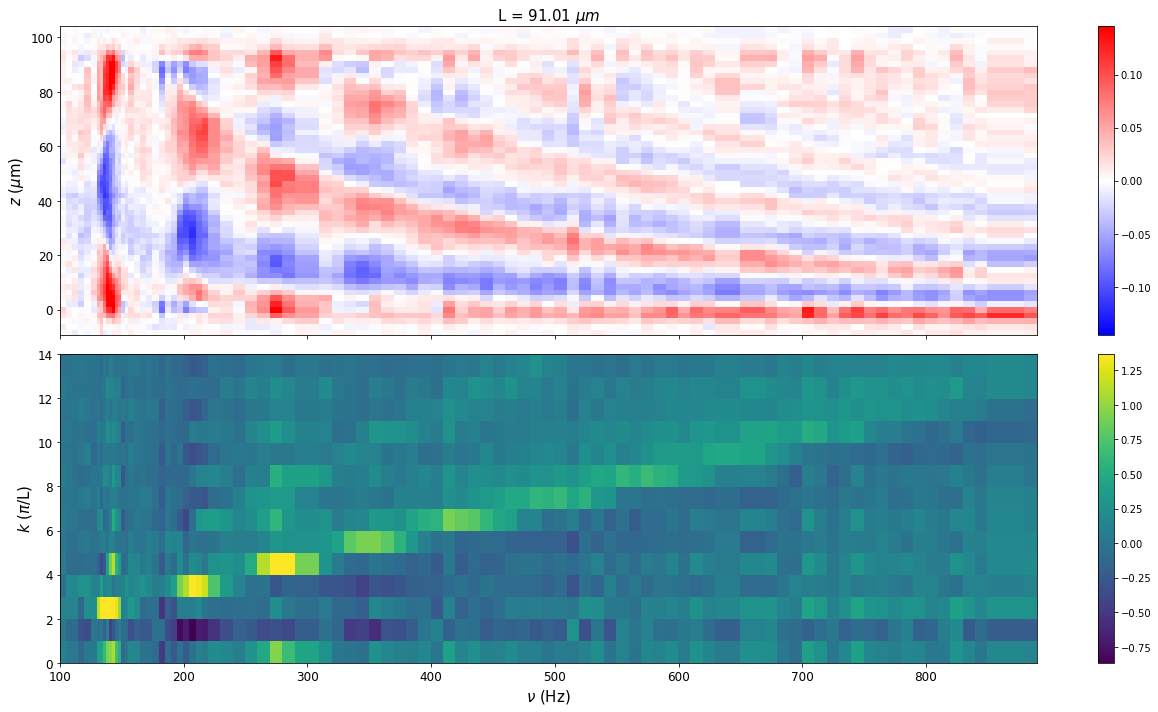

In [1595]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[18, 10], sharex=True)
plt.sca(ax[0])
plt.pcolor(*movie, cmap='bwr', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar()
plt.sca(ax[1])
plt.pcolor(*ft_real, cmap='viridis', linewidth=0, vmax=clim_ft)
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar()
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v2.pdf')

## Lorentzian Fits 

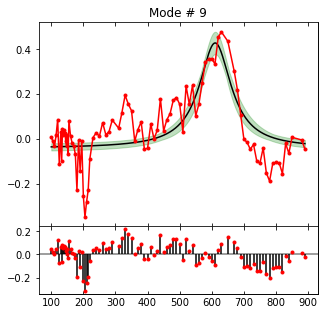

In [1596]:
# Lorentzian Fits 
mode_num = np.array([2,3,4,5,6,7,8,9])
mode_fits = []
ft = ft_real 
ref_freq_guess = 70
gamma_guess = mode_num * 5
fit_lims = {'1' : [0, 90], '2':[90, 200], '3':[130, 300], '4':[150, 500], '5':[200,600], '6' : [320, 560], '7':[200,700]}
fit_lims = dict()

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1, offset=0, )
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(str(mode_num[i]), [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

# Slider plot 
def temp(test = 0):
    ax = mode_fits[test].plot(fiterrors=True)
    ax[0].set_title('Mode # {}'.format(mode_num[test]))
    plt.sca(ax[0])
    if savefig.value: plt.savefig(suffix + 'SampleFits_Mode{}.pdf'.format(mode_num[test]))
    plt.show()
w = ipywidgets.interact(temp, test=(0, len(mode_num)-1))

In [1597]:
# Extract Data 
modes = pd.DataFrame()
modes['mode #'] = mode_num
modes['k (1/m)'] = mode_num * kscale * 1e6
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode #']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode #']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['FWHM (Hz)'] = [cf['gamma'] for cf in mode_fits]
modes['FWHM (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['FWHM (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['FWHM (Hz) error'] * twopi
modes['FT amplitude (arb.)'] = [cf['amp'] for cf in mode_fits]

modes

,mode #,k (1/m),f (Hz),f (Hz) error,f0 (Hz),f0 (Hz) error,w (1/s),w (1/s) error,FWHM (Hz),FWHM (Hz) error,gamma (1/s),gamma (1/s) error,FT amplitude (arb.)
0,2,69042.147431,138.436965,0.273773,69.218483,0.136887,869.825106,1.720167,10.831170,0.849173,68.054246,5.335514,2.906990
1,3,103563.221146,207.441666,0.988580,69.147222,0.329527,1303.394428,6.211430,26.340147,3.129166,165.500026,19.661132,1.466245
2,4,138084.294861,272.157769,1.551316,68.039442,0.387829,1710.017698,9.747205,26.552268,4.634083,166.832818,29.116805,1.861139
3,5,172605.368577,344.273063,1.885307,68.854613,0.377061,2163.131452,11.845734,47.263475,5.971985,296.965171,37.523090,1.023196
4,6,207126.442292,415.823825,3.781564,69.303971,0.630261,2612.698146,23.760269,59.202981,11.977405,371.983302,75.256256,0.850552
5,7,241647.516007,484.049960,4.099859,69.149994,0.585694,3041.375599,25.760174,83.096321,13.558007,522.109586,85.187470,0.651711
6,8,276168.589723,555.375982,6.170003,69.421998,0.771250,3489.530210,38.767272,106.281275,21.494839,667.784943,135.056056,0.560270
7,9,310689.663438,610.581762,6.782146,67.842418,0.753572,3836.398353,42.613480,120.787154,21.634590,758.928069,135.934140,0.469222


In [1598]:
# Save Data 
if savefig.value: modes.to_excel(suffix + 'FTLorentzianFits_Data.xlsx')

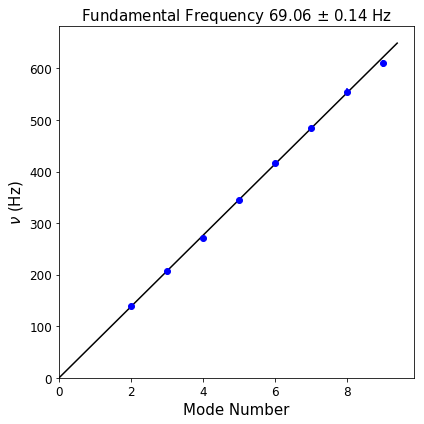

In [1599]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['mode #'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode #'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
xp = np.linspace(0, modes['mode #'].max() + 0.4)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Mode Number', fontsize=15)
plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'FundamentalFrequency_v1.pdf')

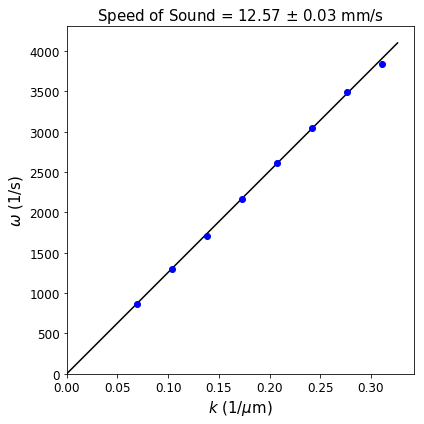

In [1600]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'Dispersion Relation_v1.pdf')

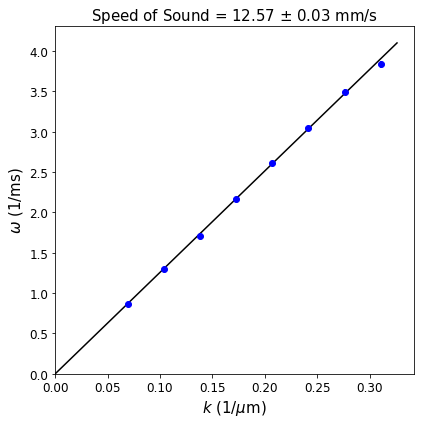

In [1601]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, info=False, plot=False)
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/ms)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'Dispersion Relation_v2.pdf')

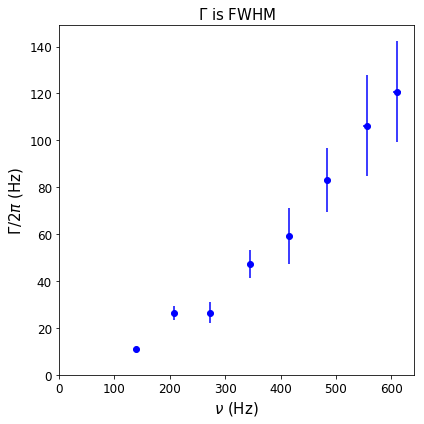

In [1602]:
# Plot Gamma vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['FWHM (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['FWHM (Hz) error'], fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'GammaVsOmega_v1.pdf')

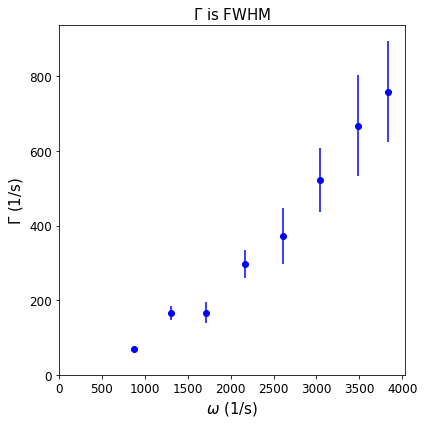

In [1603]:
# Plot Gamma vs Omega 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['w (1/s)'], modes['gamma (1/s)'], xerr=modes['w (1/s) error'], yerr=modes['gamma (1/s) error'], fmt='bo')
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ (1/s)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'GammaVsOmega_v2.pdf')

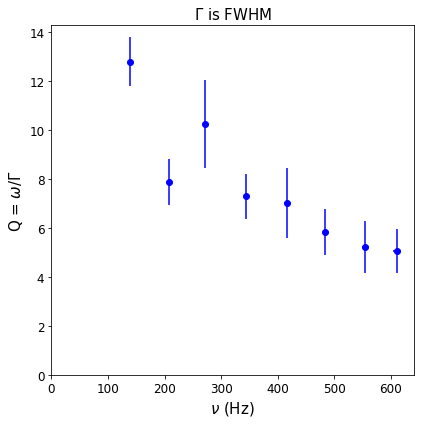

In [1604]:
# Plot Q vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['f (Hz)']/modes['FWHM (Hz)'], xerr=modes['f (Hz) error'], 
             yerr=np.sqrt((modes['f (Hz) error']/modes['FWHM (Hz)'])**2 + (modes['FWHM (Hz) error'] * modes['f (Hz)']/modes['FWHM (Hz)']**2)**2), fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'Q = $\omega / \Gamma $', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'QVsFreq_v1.pdf')

# Time Evolution

In [228]:
# Saving Figures 
savefig = ipywidgets.Checkbox(value=False, description='Save Fig')
display(savefig)
folder_name = df.iloc[0].name[0:14] + 'TimeEvolution'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix

'08-26-2017_17_TimeEvolution/'

In [229]:
# Compute movies 
z_lims = np.array([-10, 105]) * 1e-6
use = 'Delta rho'
movie = np.array([nz.trim(xlim=z_lims).y for nz in df_data[use]]).T
movie = [df_data.index.values, df_data[use].iloc[0].trim(xlim=z_lims).x*1e6, movie]

In [230]:
# Compute FT 
L = np.mean(df_data.length)
kscale = np.pi/L
k = np.arange(0, 15 * kscale, 1 * kscale)
ft = np.array([tp.fourier_transform(movie[1]*1e-6, movie[2][:, i], k)[1] for i in range(movie[0].size)]).T / 1e12
ft_real = [movie[0], k/kscale, np.real(ft)]
ft_imag = [movie[0], k/kscale, np.imag(ft)]
ft_abs = [movie[0], k/kscale, np.abs(ft)]

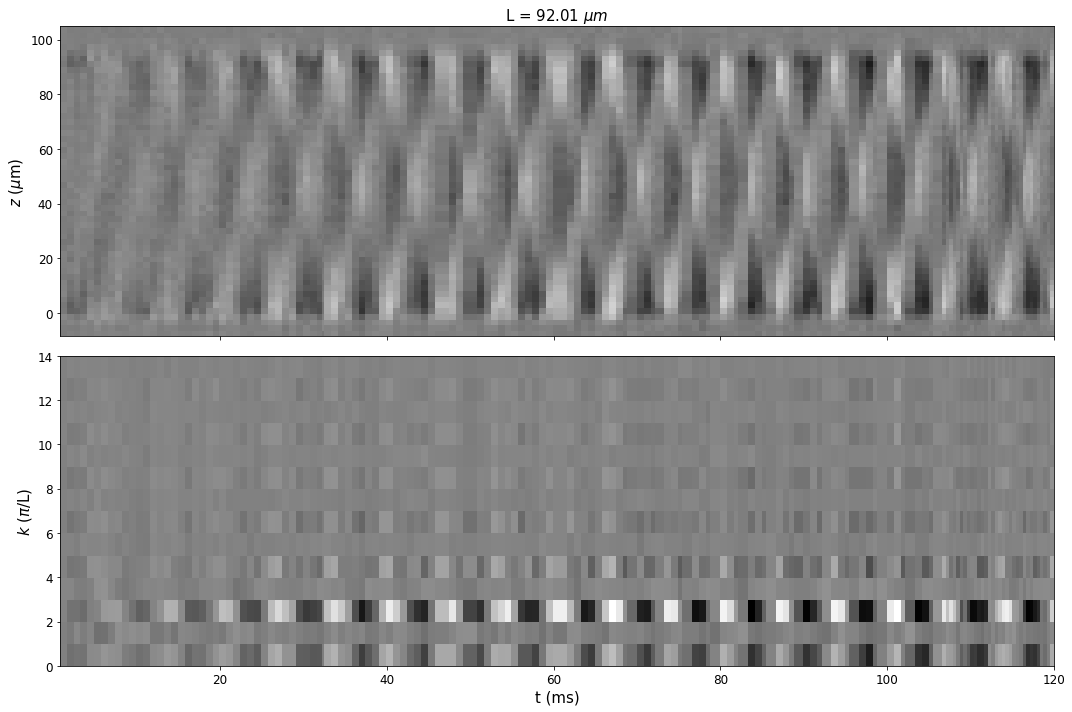

In [231]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[15, 10], sharex=True)
plt.sca(ax[0])
ax[0].pcolor(*movie, cmap='gray', vmin=-clim, vmax=clim, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L * 1e6), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.sca(ax[1])
ax[1].pcolor(*ft_real, cmap='gray', linewidth=0)
plt.xlabel(r't (ms)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v1.pdf')

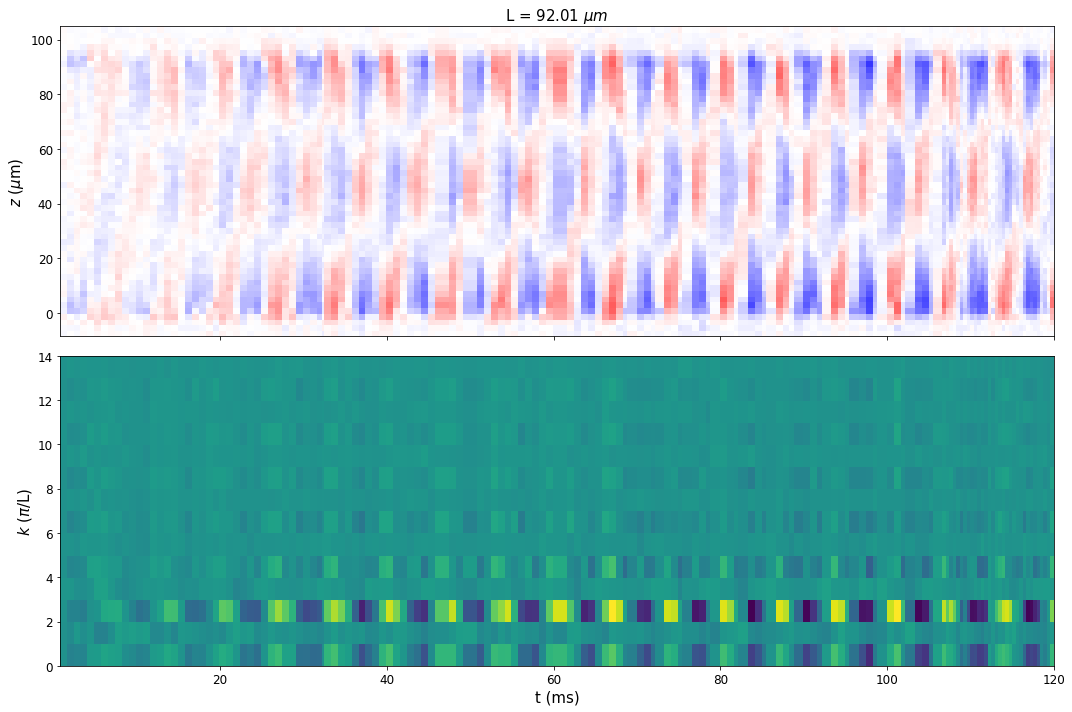

In [232]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[15, 10], sharex=True)
plt.sca(ax[0])
ax[0].pcolor(*movie, cmap='bwr', vmin=-clim, vmax=clim, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L * 1e6), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.sca(ax[1])
ax[1].pcolor(*ft_real, cmap='viridis', linewidth=0)
plt.xlabel(r't (ms)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v2.pdf')